In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import src.data.dataloaders as dld

from accelerate import Accelerator
from accelerate.utils import set_seed

import torchvision
import torchvision.transforms.v2 as v2
import torchvision.transforms.functional as F_vision

import numpy as np
import transformers

import matplotlib.pyplot as plt
from tqdm import trange

from astropy.io import fits

import glob
import os

# Data Check Out

In [2]:
main_dataset_path='/data/scratch/bariskurtkaya/dataset/torch_dataset/' 
dataset_path='/data/scratch/bariskurtkaya/dataset/torch_dataset_injection/' 
data_type='train'

psf_paths = glob.glob(os.path.join(dataset_path, data_type, '*.pth'))
main_psf_paths = glob.glob(os.path.join(main_dataset_path, '*.pth'))

In [3]:
path_1386 = []
for path in psf_paths:
    if '4451' in path:
        path_1386.append(path)

In [4]:
main_psf_paths[-5], path_1386

('/data/scratch/bariskurtkaya/dataset/torch_dataset/4451.pth', [])

In [5]:
main_1386 = torch.load(main_psf_paths[-5])

/tmp/ipykernel_109299/1531314121.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  main_1386 = torch.load(main_psf_paths[-5])


In [6]:
main_1386[0].keys(), main_1386[0]['filter_key']

(dict_keys(['filter_key', 'psfs', 'generated_psf', 'max', 'min', 'pid', 'instrume']),
 'jw04451-a3001_t002_nircam_f250m-maskbar-sub400x256alwb')

In [7]:
main_1386[0]['psfs'].shape

torch.Size([80, 256, 400])

In [9]:
psf_base = torch.load('/data/scratch/bariskurtkaya/dataset/torch_dataset_injection/test/base_jw04451-a3001_t002_nircam_f250m-maskbar-sub400x256alwb.pth')
psf_injection = torch.load('/data/scratch/bariskurtkaya/dataset/torch_dataset_injection/test/injection_jw04451-a3001_t002_nircam_f250m-maskbar-sub400x256alwb_0.pth')

/tmp/ipykernel_109299/292639524.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  psf_base = torch.load('/data/scratch/bariskurtkaya/dataset/torch_dataset_injection/test/b

In [10]:
psf_base.shape, psf_injection[0].shape

(torch.Size([80, 256, 256]), torch.Size([800, 256, 256]))

In [ ]:
# Check base PSF
center_crop = v2.CenterCrop(256)

row = 8
col = 10

fig, axs = plt.subplots(row, col, figsize=(30, 30))

for num_row in range(row):
    for num_col in range(col):
        show_psf = center_crop(main_1386[0]['psfs'])[num_row*col+num_col].cpu()
        base_psf = psf_base[num_row*col+num_col].cpu()

        axs[num_row, num_col].imshow((show_psf-base_psf).numpy())
        axs[num_row, num_col].set_axis_off()

In [12]:
psf_base = torch.repeat_interleave(psf_base, 10, dim=0)

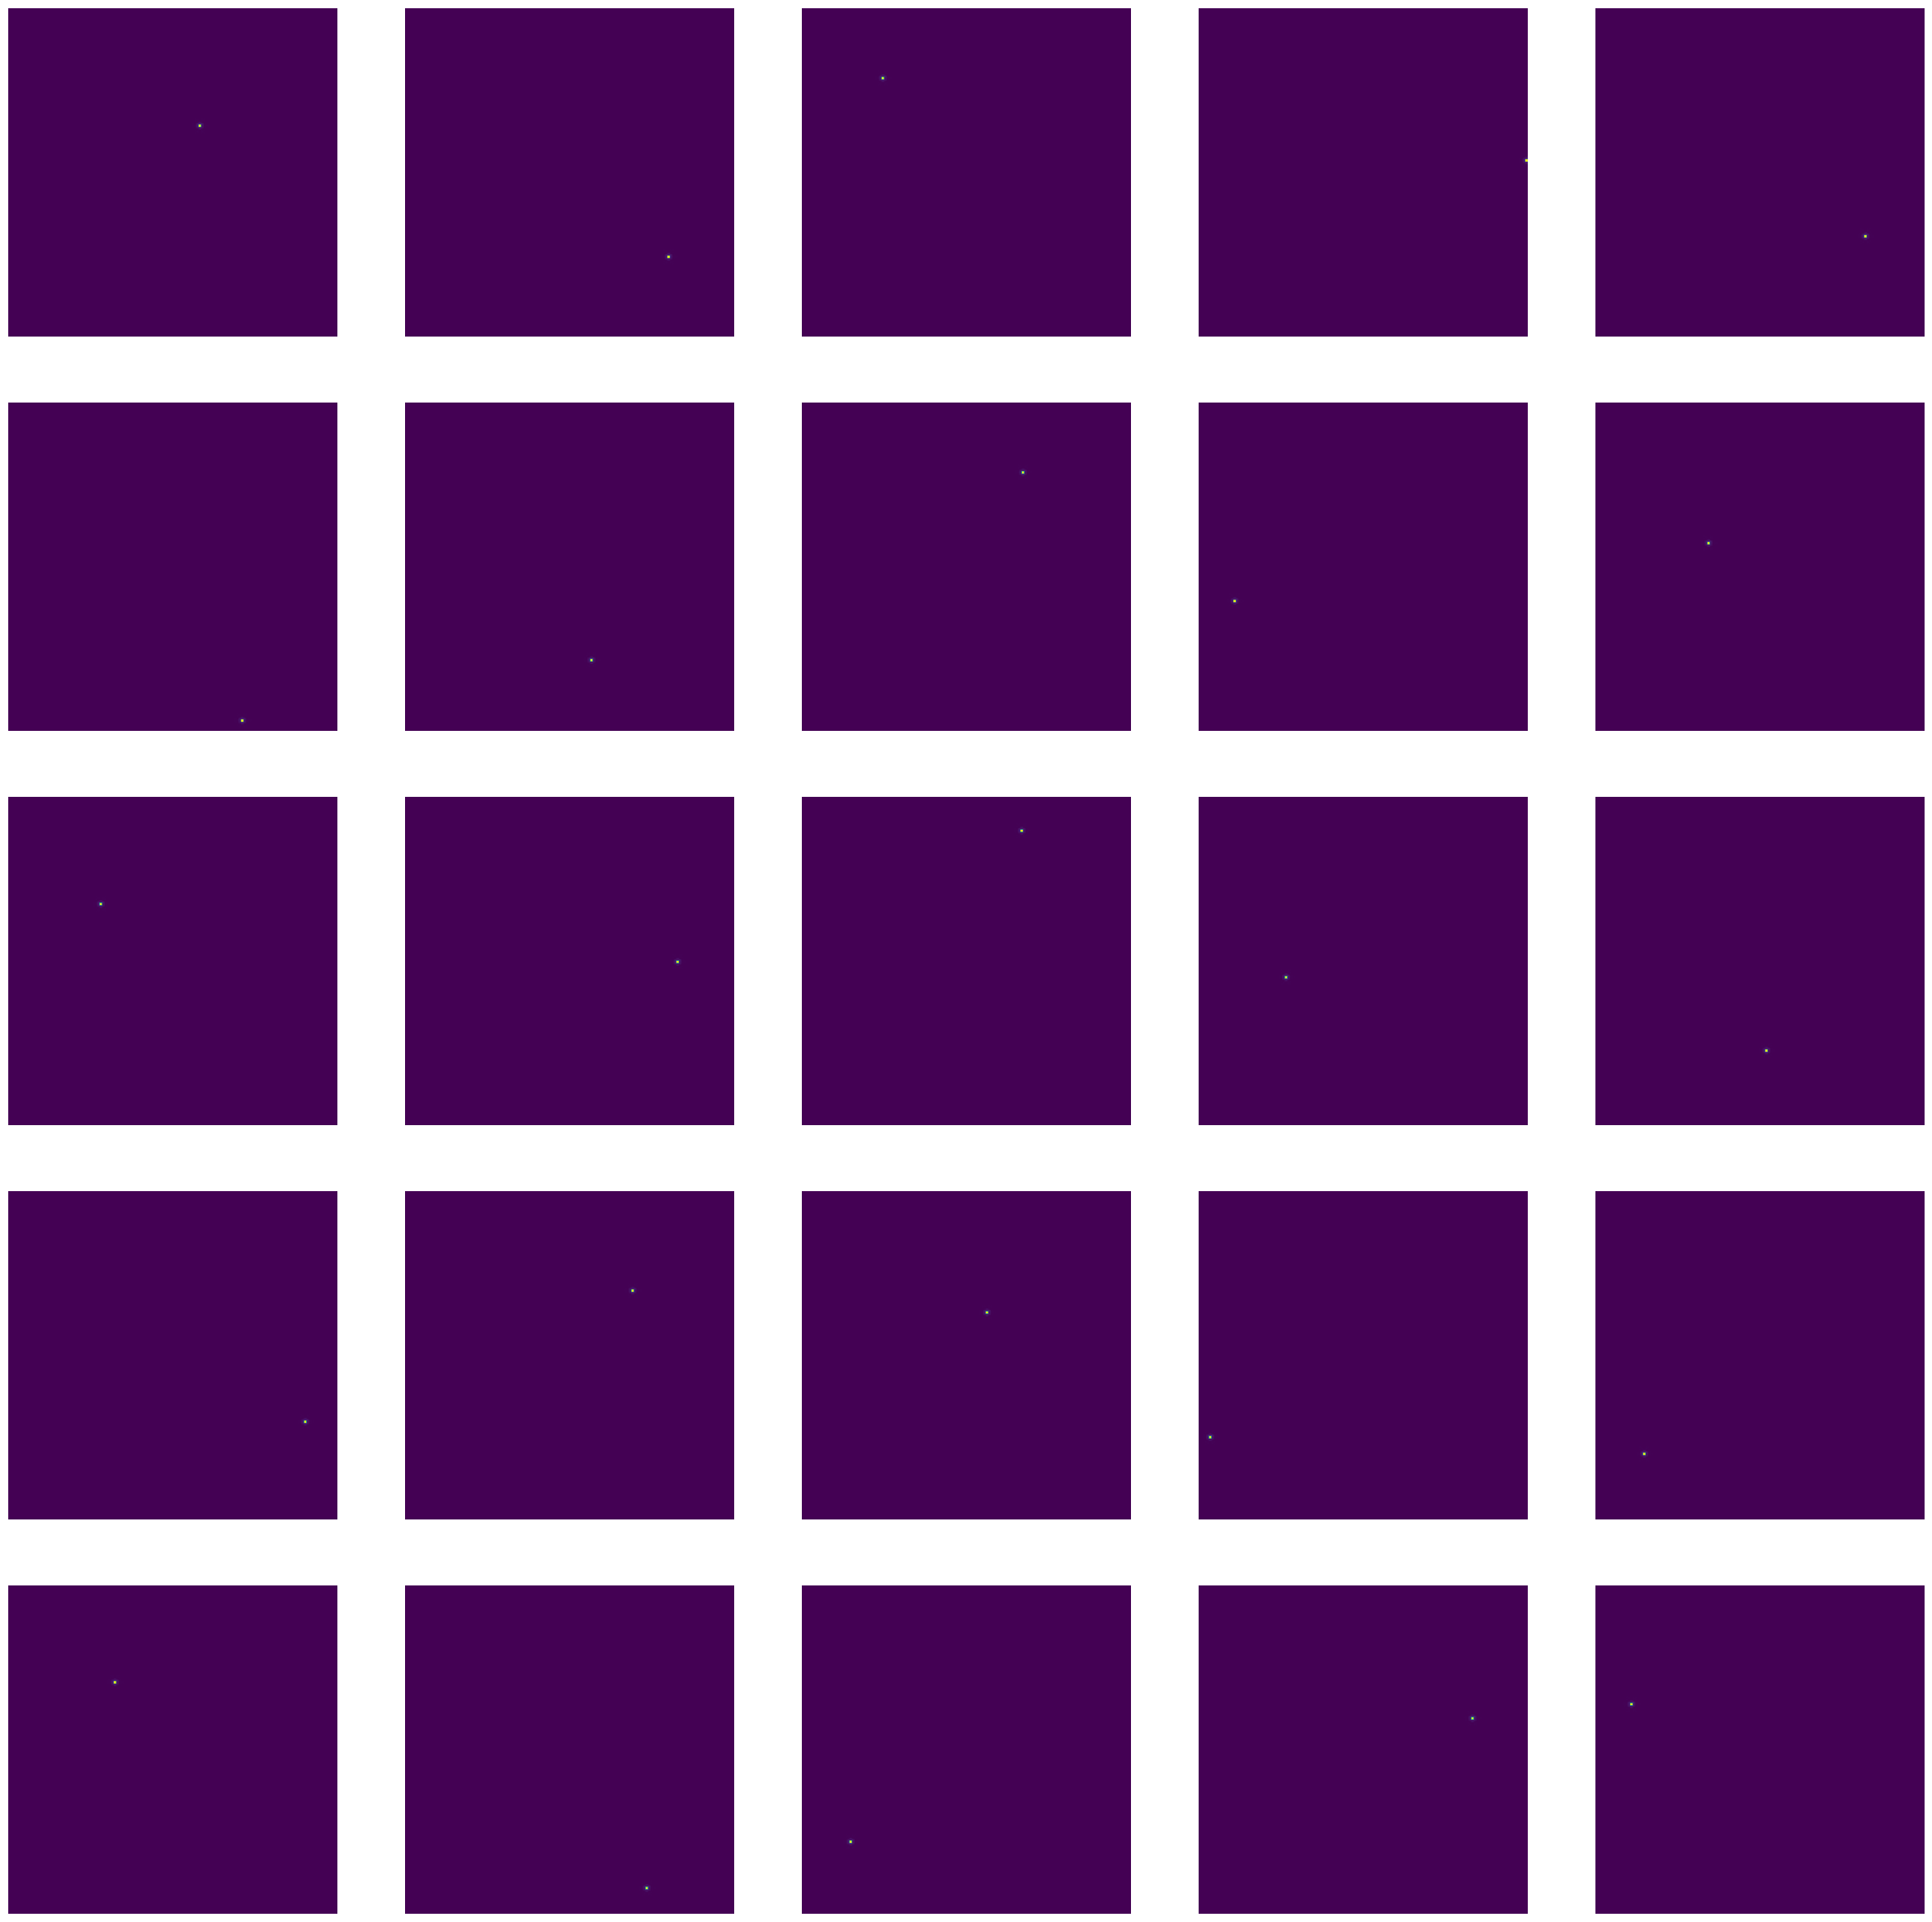

In [16]:
row = 5
col = 5

fig, axs = plt.subplots(row, col, figsize=(30, 30))

for num_row in range(row):
    for num_col in range(col):
        axs[num_row, num_col].imshow((psf_injection[0][num_row*col+num_col]-psf_base[num_row*col+num_col]).cpu().numpy())
        axs[num_row, num_col].set_axis_off()

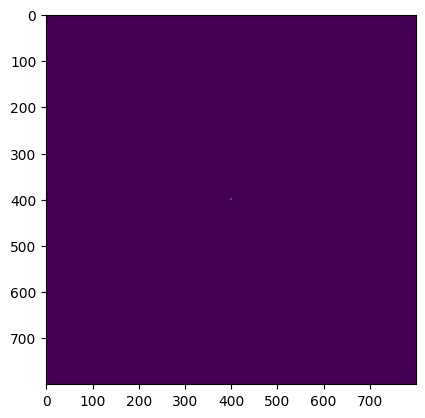

In [17]:
plt.imshow(torch.sum(psf_base[0]) * psf_injection[2][0] * main_1386[0]['generated_psf'].cpu().numpy())

In [18]:
center_crop = v2.CenterCrop(512)

test = center_crop(main_1386[0]['generated_psf'])
test_gen = torch.sum(psf_base[0]) * 1e-5 * test

x, y = psf_injection[1][0] - 128
crop_test = F_vision.crop(test_gen, int(y), int(x), 256, 256)

In [19]:
torch.sum(test), torch.max(test)

(tensor(0.9973, device='cuda:0'), tensor(0.1645, device='cuda:0'))

In [20]:
exo_x, exo_y = 256-x, 256-y

In [32]:
torch.sum(psf_base[0])

tensor(974666.3750)

In [21]:
torch.max(psf_base[0]), torch.max(crop_test)

(tensor(3640.7200), tensor(1.4001e-05, device='cuda:0'))

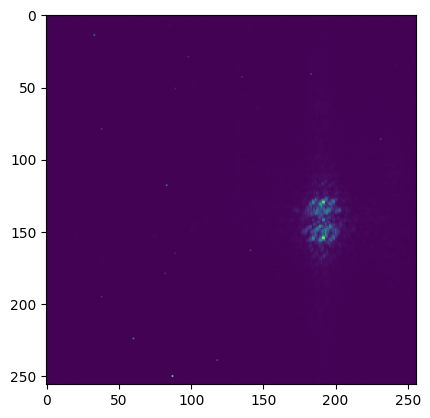

In [22]:
plt.imshow((psf_base[0].cpu()+crop_test.cpu()).numpy())

In [29]:
128+66

194

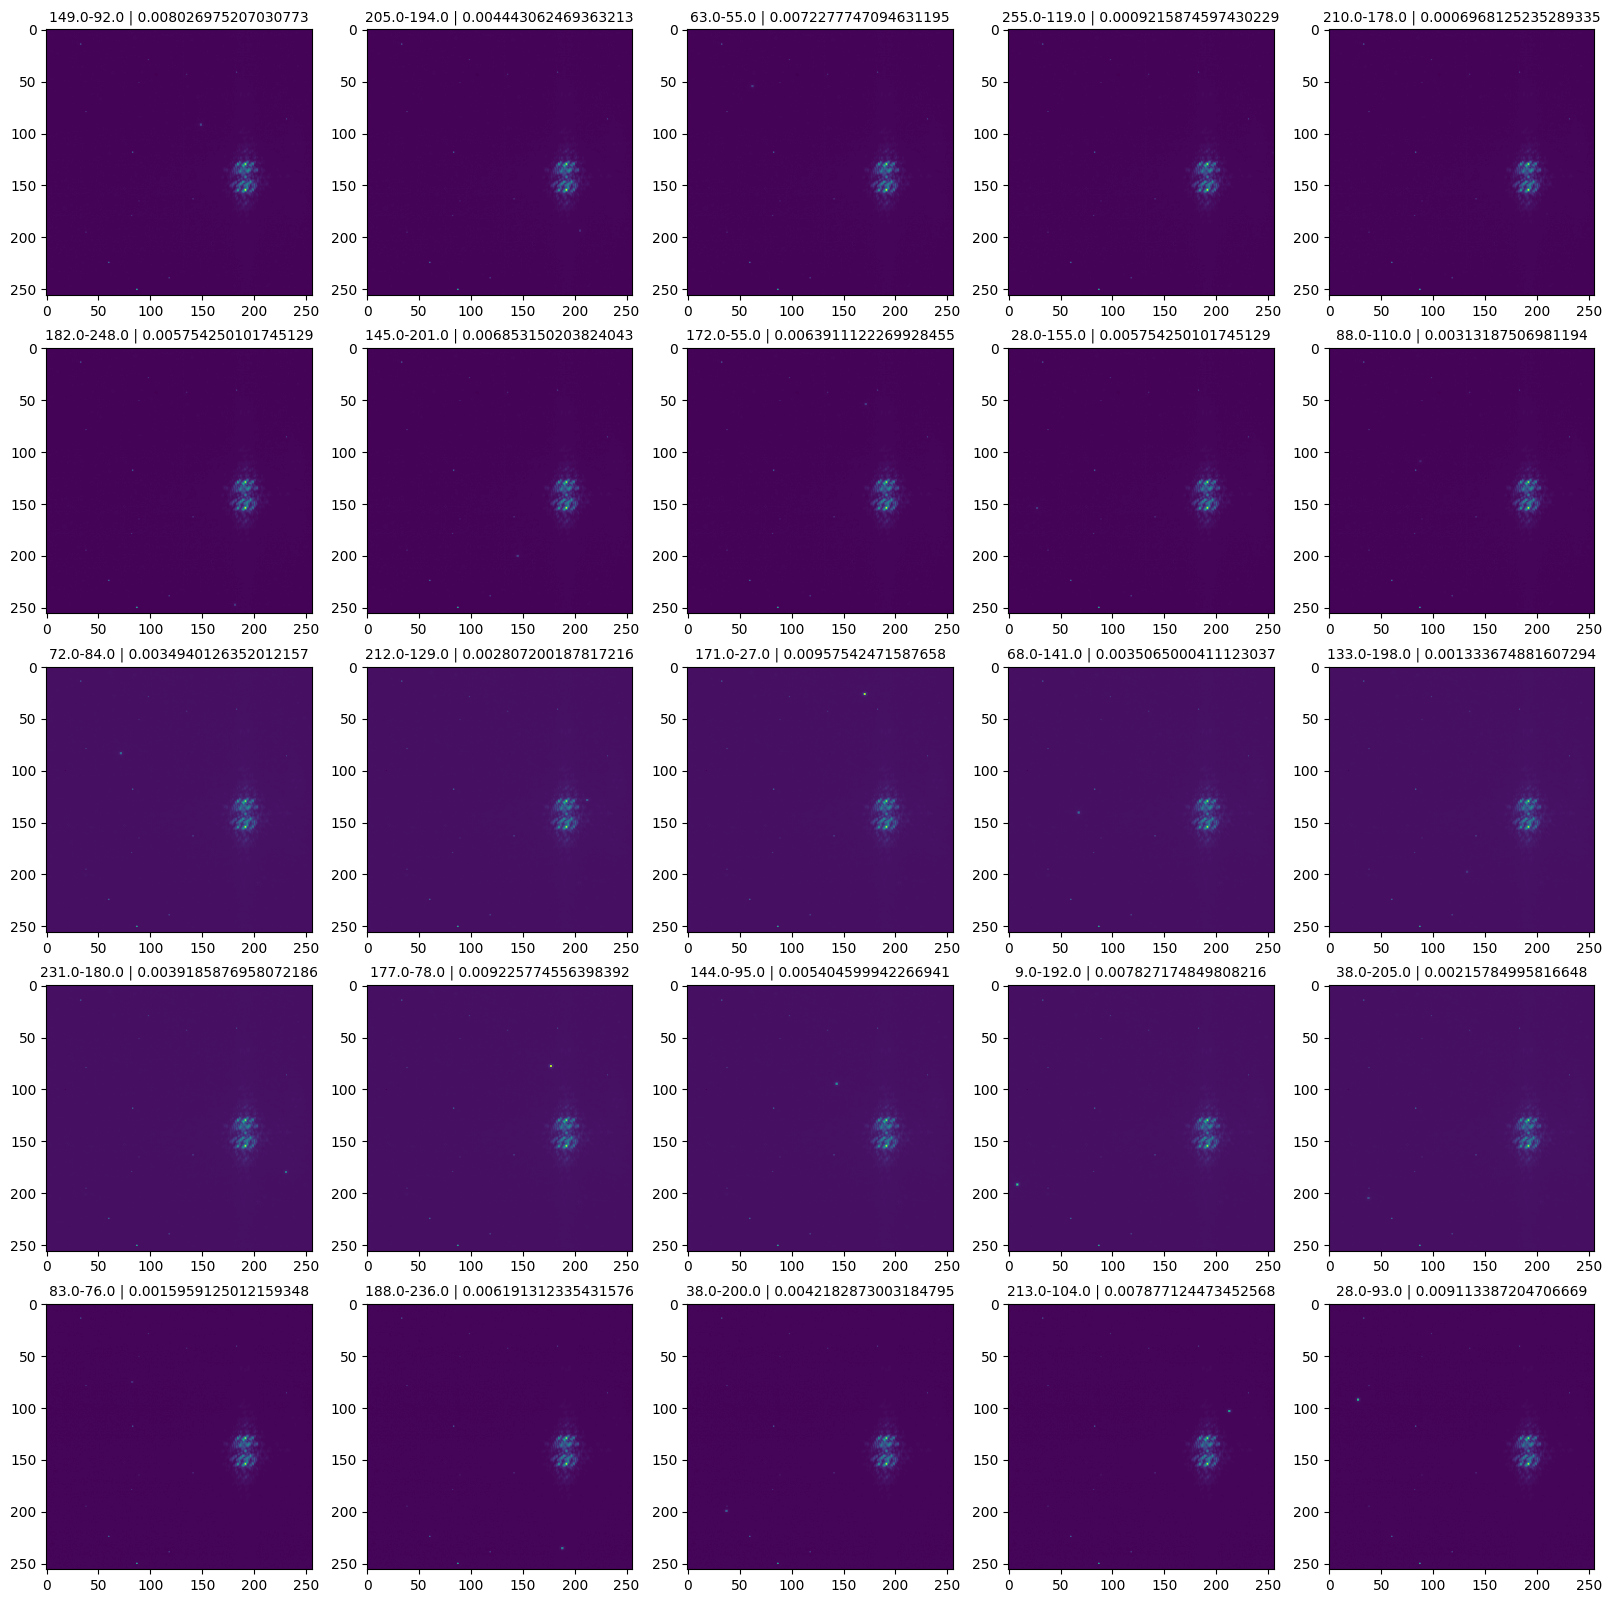

In [31]:
row = 5
col = 5

fig, axs = plt.subplots(row, col, figsize=(20, 20))


for num_row in range(row):
    for num_col in range(col):
        idx = num_row*col+num_col + 20
        axs[num_row, num_col].imshow((psf_injection[0][idx]).cpu().numpy())
        # axs[num_row, num_col].imshow((psf_injection[0][idx]-psf_base[idx]).cpu().numpy())
        axs[num_row, num_col].set_title(f'{(128+psf_injection[1][idx][0])}-{(128+psf_injection[1][idx][1])} | {psf_injection[2][idx]}', fontsize=10)

# Machine Learning

In [ ]:
set_seed(42)
DEVICE = 'cuda'

num_epochs = 20
lr = 1e-3
batch_size = 128

In [ ]:
# accelerator = Accelerator()

In [ ]:
train_dataset = dld.SynthDatasetv2(data_type='train')
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)

test_dataset = dld.SynthDatasetv2(data_type='test')
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=True)

In [ ]:
vis_trans_config = transformers.ViTConfig(image_size=256, num_channels=1, attn_implementation="eager")

In [ ]:
vis_trans = transformers.ViTForImageClassification(vis_trans_config).to(DEVICE)

In [ ]:
optimizer = torch.optim.AdamW(vis_trans.parameters(), lr=lr)

In [ ]:
# vis_trans, optimizer, train_dataloader = accelerator.prepare(vis_trans, optimizer, train_dataloader)

In [ ]:
loss_list = []
accuracy_list = []

In [ ]:
loss_list = list(loss_list)
accuracy_list = list(accuracy_list)

with trange(num_epochs) as pbar:
    for epoch in pbar:
        vis_trans.train()
        accuracy = 0

        for idx, (data, label) in enumerate(train_dataloader):
            data, label = data.to(DEVICE), label.to(DEVICE)
            optimizer.zero_grad()

            # loss, logits, hidden_states, attentionskkio 
            out = vis_trans(data.unsqueeze(1), labels=label)
            
            # accelerator.backward(out[0])
            out[0].backward()
            optimizer.step()

            accuracy += torch.sum(torch.argmax(out[1], dim=1) == label) / label.shape[0]

            loss_list.append(out[0].item())
            pbar.set_postfix(loss=out[0])

        accuracy_list.append((accuracy/len(train_dataloader)).item())

loss_list = np.array(loss_list)
accuracy_list = np.array(accuracy_list)

In [ ]:
def numpy_ewma_vectorized_v2(data, window):

    alpha = 2 /(window + 1.0)
    alpha_rev = 1-alpha
    n = data.shape[0]

    pows = alpha_rev**(np.arange(n+1))

    scale_arr = 1/pows[:-1]
    offset = data[0]*pows[1:]
    pw0 = alpha*alpha_rev**(n-1)

    mult = data*pw0*scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums*scale_arr[::-1]
    return out

In [ ]:
plt.plot(np.arange(loss_list.shape[0]), loss_list)

In [ ]:
ewma_loss = numpy_ewma_vectorized_v2(loss_list, 100)

In [ ]:
plt.plot(np.arange(ewma_loss.shape[0]), ewma_loss)

In [ ]:
accuracy = 0

with torch.no_grad():
    vis_trans.eval()

    for idx, (data, label) in enumerate(test_dataloader):
        data, label = data.to(DEVICE), label.to(DEVICE)

        # loss, logits, hidden_states, attentionskkio 
        out = vis_trans(data.unsqueeze(1), labels=label, output_attentions=True)
        
        accuracy += torch.sum(torch.argmax(out[1], dim=1) == label)  

In [ ]:
print(accuracy / (len(test_dataloader) * batch_size))

In [ ]:
len(out.attentions), out.attentions[11].shape

In [ ]:
attn = torch.sum(out.attentions[11], dim=1)[:, 0, 1:].view(-1, 16, 16).detach()
attn_resized = nn.functional.interpolate(attn.unsqueeze(1), size=(256, 256)).view(-1, 256, 256)

In [ ]:
pred = torch.argmax(out[1], dim=1).cpu().numpy()

n_row = 8
n_col = 14

fig, axs = plt.subplots(n_row, n_col, figsize=(45, 30))

for row in range(n_row):
    for col in range(n_col):
        axs[row, col].imshow(data[row*8+col].cpu().numpy())
        axs[row, col].imshow(attn_resized[row*8+col].cpu().numpy(), cmap='viridis', alpha=0.3)
        axs[row, col].set_title(f'Acc: {"True" if label[row*8+col] == pred[row*8+col] else "False"} - Label: {label[row*8+col].cpu().numpy()}, - Pred: {pred[row*8+col]}')
        axs[row, col].set_axis_off()

In [ ]:
torch.save(vis_trans, 'checkpoints/vis_transformer_01-09-2024_v2.ckpt')

In [ ]:
i2d_data = fits.open('/data/scratch/bariskurtkaya/dataset/NIRCAM/1386/mastDownload/JWST/jw01386-a3001_t003_nircam_f250m-maskrnd-sub320a335r_i2d.fits')[1].data
psf_data = fits.open('/data/scratch/bariskurtkaya/dataset/NIRCAM/1386/mastDownload/JWST/jw01386-a3001_t004_nircam_f356w-maskrnd-sub320a335r_psfstack.fits')[1].data

In [ ]:
plt.imshow(i2d_data)

In [ ]:
plt.imshow(np.array(psf_data)[0])

In [ ]:
i2d_data = torch.nan_to_num(torch.from_numpy(np.array(i2d_data, dtype=np.float32)).cuda())
psf_data = torch.nan_to_num(torch.from_numpy(np.array(psf_data, dtype=np.float32)).cuda())

In [ ]:
center_crop = torchvision.transforms.CenterCrop(256)

In [ ]:
center_crop(i2d_data[None, None, ...]).shape, center_crop(psf_data.unsqueeze(1)).shape

In [ ]:
vis_trans.eval()
out_i2d = vis_trans(center_crop(i2d_data[None, None, ...]))
out_psf = vis_trans(center_crop(psf_data.unsqueeze(1)))

In [ ]:
torch.max(out_i2d.logits, dim=1).indices, torch.max(out_psf.logits, dim=1).indices